#### Курсовой проект по по курсу "Python для Data Science"

#### Cлушатель: Перфильев Дмитрий

#### Задание:

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


#### Решение:

##### Загружаем необходимые библиотеки. Устанавливаем настройки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

##### Загрузим данные из файла data_train.csv по которым построим модель. 

In [2]:
data_train = pd.read_csv('DATA/train.csv', sep=',')
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


##### Загрузим данные по которым будем делать прогноз цен

In [3]:
data_test = pd.read_csv('DATA/test.csv', sep=',')
data_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


##### Вспомагательные функции

In [4]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def k_min(data):
    return data['Square'].mean() / (data['Rooms'].mean() + data['Rooms'].std())

def k_max(data):
    return data['Square'].mean() / (data['Rooms'].mean() - data['Rooms'].std())

def create_model(X_train, y_train, X_test, y_test, feats, model):
    model.fit(X_train.loc[:, feats], y_train)
    y_pred = model.predict(X_test.loc[:, feats])
    mse_rate = mean_squared_error(y_test, y_pred)
    r2_rate = r2(y_test, y_pred)
    return {'mse':  mse_rate, 'r2': r2_rate}

def mean_group(data,name_col):
    return data.loc[data[name_col],name_col].mean()

def ratio(x, y):
    if y == 0:
        return print(f'Делитель = 0')
    return x / y

#### Оценим качество данных. Произведем первичную обработку данных.

##### Оценим количество отсутствующих полей

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


##### Заполним недостающие поля Healthcare_1 средним значением по району.

In [7]:
data_train['Healthcare_1'] = data_train['Healthcare_1'].fillna(data_train['Healthcare_1'].mean())
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [8]:
data_test['Healthcare_1'] = data_test['Healthcare_1'].fillna(data_test['Healthcare_1'].mean())
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


##### Преобразуем категориальные признаки Ecology_2 Ecology_3  

In [9]:
data_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [10]:
data_test['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [11]:
data_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [12]:
data_test['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [13]:
data_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [14]:
data_test['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [15]:
data_test['Ecology_2'] = (data_train['Ecology_2'] == 'B').astype(int)
data_test['Ecology_3'] = (data_train['Ecology_3'] == 'B').astype(int)
data_test['Shops_2'] = (data_train['Shops_2'] == 'B').astype(int)

In [16]:
data_train['Ecology_2'] = (data_train['Ecology_2'] == 'B').astype(int)
data_train['Ecology_3'] = (data_train['Ecology_3'] == 'B').astype(int)
data_train['Shops_2'] = (data_train['Shops_2'] == 'B').astype(int)

In [17]:
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,1142.90446,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.00000,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.00000,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.00000,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.00000,2,4,1,150226.531644


In [18]:
data_train.shape, data_test.shape

((10000, 20), (5000, 19))

##### Найдем аномалии в данных в столбще HouseYear.


In [19]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [20]:
data_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990800,0.972200,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.915200
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,0.095484,0.164416,17.532202,4026.614773,23.863762,756.632091,1.47994,4.777365,0.278612
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,1146.657263,1.00000,3.000000,1.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,1146.657263,2.00000,6.000000,1.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


#####  Преобразуем данные HouseYear - вычислим возраст домов. 

In [21]:
data_train.loc[(2020 - data_train['HouseYear'] < 0) | (2020 - data_train['HouseYear'] > 100),'HouseYear']

910         1914
1380        1917
1386        1918
1497    20052011
2554        1918
2608        1919
2656        1912
2902        1918
4189        4968
4904        1919
5016        1918
5053        1917
5111        1912
7562        1919
7611        1916
8144        1917
8505        1918
9317        1910
Name: HouseYear, dtype: int64

In [22]:
data_test.loc[(2020 - data_test['HouseYear'] < 0) | (2019 - data_test['HouseYear'] > 100),'HouseYear']

2       1909
64      1911
600     1917
1475    1912
2323    1918
2691    1910
2856    1914
3253    1908
3337    1918
3654    1918
Name: HouseYear, dtype: int64

In [23]:
data_train.loc[data_train['HouseYear'] == 20052011,'HouseYear'] = 2011
data_train.loc[data_train['HouseYear'] == 4968,'HouseYear'] = 1968

In [24]:
data_train['HouseYear'] = 2020 - data_train['HouseYear']
data_test['HouseYear'] = 2020 - data_test['HouseYear']

In [25]:
data_train['HouseYear'].describe()

count    10000.000000
mean        35.133700
std         18.412271
min          0.000000
25%         19.000000
50%         43.000000
75%         46.000000
max        110.000000
Name: HouseYear, dtype: float64

##### Оценим данные Price

In [26]:
data_train['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [27]:
data_train.loc[data_train['Price'] > 600000,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1537,3206,54,3.0,125.117838,NaN,1.0,4,1.0,43,0.006076,1,1,30,5285,0,645.00000,6,6,1,625820.041178
2442,13532,146,3.0,106.246398,64.451747,14.0,9,18.0,10,0.236108,1,1,16,3893,27,1142.90446,3,10,1,616857.135464
2857,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,60,0.200147,1,1,23,3975,8,770.00000,2,0,1,600903.828562
3228,15192,26,3.0,117.714551,57.440648,15.0,17,30.0,8,0.000000,1,1,36,6714,2,2672.00000,0,2,1,624680.099059
3305,15749,66,3.0,78.747853,33.885760,11.0,2,5.0,65,0.161976,1,0,31,7010,5,4508.00000,3,7,1,606958.937510
3890,9840,108,3.0,78.824038,53.016323,8.0,2,8.0,62,0.000000,1,1,23,3684,2,1142.90446,0,4,1,611542.063430
3937,6808,146,3.0,106.867638,64.341756,14.0,4,22.0,9,0.236108,1,1,16,3893,27,1142.90446,3,10,1,610557.405615
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,23,0.090799,1,1,74,19083,2,1142.90446,5,15,1,622888.825328
4764,11013,43,2.0,58.757047,34.605286,8.0,12,17.0,16,0.000078,1,1,22,6398,141,1046.00000,3,23,1,625678.644994
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,7,0.151346,1,0,32,5889,10,830.00000,4,1,1,624549.354546


In [28]:
data_train.loc[data_train['Price'] < 60000,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3605,7243,9,2.0,58.089253,52.460857,8.0,5,22.0,39,0.136244,1,1,11,2370,0,1142.90446,0,1,1,59877.592523
9732,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,32,0.306977,1,1,27,5148,14,1575.00000,5,7,1,59174.778028


##### Оценим данные Rooms

In [29]:
data_train['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [30]:
data_test['Rooms'].describe()

count    5000.000000
mean        1.910000
std         0.838594
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        17.000000
Name: Rooms, dtype: float64

In [31]:
arr_index = data_test.loc[(data_test['Rooms'] < 1) & (data_test['HouseYear'] > 20),:].index
data_test.iloc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,43,0.437885,1,1,23,5735,3,1084.000000,0,5,1
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,43,0.017647,1,1,2,469,0,1146.657263,0,0,1


In [32]:
for item in arr_index:
    data_test.loc[item,"Rooms"] = round(data_test.loc[(data_test.loc[item,"Square"] - 25  < data_test["Square"]) & 
                                                        (data_test["Square"] <  data_test.loc[item,"Square"] + 25) & 
                                                        (data_test["HouseYear"] == data_test.loc[item, "HouseYear"]),"Rooms"].mean())

In [33]:
data_test.iloc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,3.0,116.824201,113.692424,0.0,3,3.0,43,0.437885,1,1,23,5735,3,1084.000000,0,5,1
2524,10729,27,2.0,76.345154,42.820796,12.0,14,0.0,43,0.017647,1,1,2,469,0,1146.657263,0,0,1


In [34]:
arr_index = data_train.loc[(data_train['Rooms'] < 1) & (data_train['HouseYear'] > 20),:].index

In [35]:
data_train.iloc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,43,0.211401,1,1,9,1892,0,1142.90446,0,1,1,98129.976788
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,43,0.243205,1,1,5,1564,0,540.00000,0,0,1,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,43,0.017647,1,1,2,469,0,1142.90446,0,0,1,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,38,0.127376,1,1,43,8429,3,1142.90446,3,9,1,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,43,0.211401,1,1,9,1892,0,1142.90446,0,1,1,219281.918007


In [36]:
for item in arr_index:
    data_train.loc[item,"Rooms"] = round(data_train.loc[(data_train.loc[item,"Square"] - 25  < data_train["Square"]) & 
                                                        (data_train["Square"] <  data_train.loc[item,"Square"] + 25) & 
                                                        (data_train["HouseYear"] == data_train.loc[item, "HouseYear"]),"Rooms"].mean())

In [37]:
data_train.loc[arr_index,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2269,7317,27,1.0,41.790881,NaN,0.0,13,0.0,43,0.211401,1,1,9,1892,0,1142.90446,0,1,1,98129.976788
4366,456,6,2.0,81.491446,NaN,0.0,4,0.0,43,0.243205,1,1,5,1564,0,540.00000,0,0,1,212864.799112
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,43,0.017647,1,1,2,469,0,1142.90446,0,0,1,126596.941798
6149,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,38,0.127376,1,1,43,8429,3,1142.90446,3,9,1,158998.110646
8834,9443,27,2.0,87.762616,85.125471,0.0,5,15.0,43,0.211401,1,1,9,1892,0,1142.90446,0,1,1,219281.918007


In [38]:
data_train.loc[data_train['Rooms'] >= 6,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,18,0.090799,1,1,74,19083,2,1142.90446,5,15,1,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,6,0.007122,1,1,1,264,0,1142.90446,0,1,1,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,51,0.033494,1,1,66,10573,1,1322.00000,3,8,1,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,26,0.161532,1,1,25,5648,1,30.00000,2,4,1,172329.270863


In [39]:
data_test.loc[data_test['Rooms'] >= 6,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,5,0.014073,1,1,2,475,0,1146.657263,0,0,1
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,3,0.041116,1,1,53,14892,4,1146.657263,1,4,1
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,33,0.093443,1,1,23,4635,5,3300.000000,2,4,0


In [40]:
data_test.loc[data_test['Rooms'] == 17,:] = 1

In [41]:
data_train['Rooms'].describe()

count    10000.00000
mean         1.89120
std          0.83859
min          0.00000
25%          1.00000
50%          2.00000
75%          2.00000
max         19.00000
Name: Rooms, dtype: float64

In [42]:
data_test['Rooms'].describe()

count    5000.000000
mean        1.907800
std         0.810327
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: Rooms, dtype: float64

##### Оценим данные в колнках  Square LifeSquare

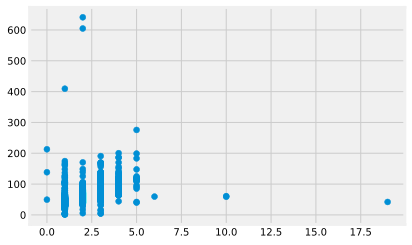

In [43]:
plt.scatter(data_train['Rooms'],  data_train['Square'])

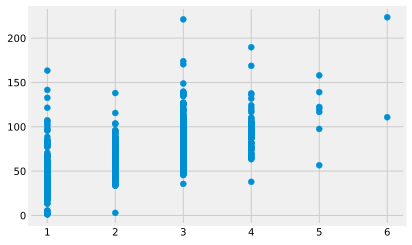

In [44]:
plt.scatter(data_test['Rooms'],  data_test['Square'])

In [45]:
data_train[['Square','LifeSquare', 'Rooms', "HouseYear"]].describe()

,Square,LifeSquare,Rooms,HouseYear
count,10000.000000,7887.000000,10000.00000,10000.000000
mean,56.315775,37.199645,1.89120,35.133700
std,21.058732,86.241209,0.83859,18.412271
min,1.136859,0.370619,0.00000,0.000000
25%,41.774881,22.769832,1.00000,19.000000
50%,52.513310,32.781260,2.00000,43.000000
75%,65.900625,45.128803,2.00000,46.000000
max,641.065193,7480.592129,19.00000,110.000000


In [46]:
data_test[['Square','LifeSquare', 'Rooms', "HouseYear"]].describe()

,Square,LifeSquare,Rooms,HouseYear
count,5000.000000,3959.000000,5000.000000,5000.00000
mean,56.439127,36.150847,1.907800,35.60100
std,19.108817,17.833950,0.810327,18.57956
min,1.000000,0.333490,1.000000,0.00000
25%,41.898338,23.091332,1.000000,20.00000
50%,52.921340,32.925087,2.000000,43.00000
75%,66.285129,45.174091,2.000000,47.00000
max,223.453689,303.071094,6.000000,112.00000


In [47]:
k_min_train = k_min(data_train)
k_max_train = k_max(data_train) 
k_min_train, k_max_train

(20.630077385901142, 53.501073972901644)

In [48]:
k_min_test = k_min(data_test)
k_max_test = k_max(data_test) 
k_min_test, k_max_test

(20.763974219528656, 51.42645643630044)

In [49]:
arr_index = data_test.loc[data_test['Square'] < data_test['Rooms'] * k_min_test/1.5,:].index

In [50]:
data_test.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,111,0.000000,1,1,30,7538,87,4702.000000,5,5,1
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,43,0.049637,1,0,34,7759,0,229.000000,1,3,1
263,11407,79,4.0,37.920348,21.357487,6.0,6,17.0,6,0.307467,1,1,30,5048,9,325.000000,2,5,1
599,8494,21,3.0,35.585010,34.674037,6.0,8,9.0,45,0.194489,1,1,47,8004,3,125.000000,3,5,1
608,16401,30,1.0,2.645046,4.338755,1.0,2,1.0,43,0.000078,1,1,22,6398,141,1046.000000,3,23,1
837,2138,27,1.0,5.647458,1.501582,1.0,1,1.0,43,0.017647,1,1,2,469,0,1146.657263,0,0,1
1165,10120,6,1.0,5.100672,3.861780,1.0,3,1.0,43,0.243205,1,1,5,1564,0,540.000000,0,0,1
3398,1,1,1.0,1.000000,1.000000,1.0,1,1.0,1,1.000000,1,1,1,1,1,1.000000,1,1,1
3697,15435,21,1.0,13.305531,9.495367,0.0,6,5.0,55,0.194489,1,1,47,8004,3,125.000000,3,5,1
3912,6060,53,5.0,56.600162,2.742068,1.0,6,18.0,43,0.049637,1,1,34,7759,0,229.000000,1,3,1


In [51]:
data_test.loc[data_test['Square'] < 10 ,'Square'] = data_test['Rooms'] * data_test['Square'].mean()/data_test['Rooms'].mean()

In [52]:
for index in data_test.loc[data_test['Square'] < data_test['Rooms'] * k_min_test/1.5,:].index:
    rooms = round(data_test.loc[index,'Square']/k_min_test)
#     rooms = round(data_test.loc[index,'Square']/data_test['Square'].mean())
    if rooms == 0:
        rooms = 1
    data_test.loc[index,'Rooms'] = rooms

In [53]:
data_test.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,111,0.000000,1,1,30,7538,87,4702.000000,5,5,1
66,9011,53,1.0,29.583356,1.353573,1.0,1,1.0,43,0.049637,1,0,34,7759,0,229.000000,1,3,1
263,11407,79,2.0,37.920348,21.357487,6.0,6,17.0,6,0.307467,1,1,30,5048,9,325.000000,2,5,1
599,8494,21,2.0,35.585010,34.674037,6.0,8,9.0,45,0.194489,1,1,47,8004,3,125.000000,3,5,1
608,16401,30,1.0,29.583356,4.338755,1.0,2,1.0,43,0.000078,1,1,22,6398,141,1046.000000,3,23,1
837,2138,27,1.0,29.583356,1.501582,1.0,1,1.0,43,0.017647,1,1,2,469,0,1146.657263,0,0,1
1165,10120,6,1.0,29.583356,3.861780,1.0,3,1.0,43,0.243205,1,1,5,1564,0,540.000000,0,0,1
3398,1,1,1.0,29.583356,1.000000,1.0,1,1.0,1,1.000000,1,1,1,1,1,1.000000,1,1,1
3697,15435,21,1.0,13.305531,9.495367,0.0,6,5.0,55,0.194489,1,1,47,8004,3,125.000000,3,5,1
3912,6060,53,3.0,56.600162,2.742068,1.0,6,18.0,43,0.049637,1,1,34,7759,0,229.000000,1,3,1


In [54]:
arr_index = data_train.loc[data_train['Square'] < data_train['Rooms'] * k_min_train/1.5,:].index

In [55]:
data_train.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,43,0.127376,1,1,43,8429,3,1142.90446,3,9,1,412511.088764
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,18,0.090799,1,1,74,19083,2,1142.90446,5,15,1,317265.323792
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,43,0.011654,1,1,4,915,0,1142.90446,0,0,1,107604.269441
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,6,0.007122,1,1,1,264,0,1142.90446,0,1,1,78364.616704
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,6,0.243205,1,1,5,1564,0,540.00000,0,0,1,137597.601458
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,51,0.033494,1,1,66,10573,1,1322.00000,3,8,1,229661.964416
2247,16772,109,3.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,262.00000,3,6,1,173602.708629
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,1142.90446,0,0,1,112693.641769
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,7,0.211401,1,1,9,1892,0,1142.90446,0,1,1,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,43,0.150818,1,1,16,3433,4,2643.00000,4,5,1,369472.403061


In [56]:
data_train.loc[data_train['Square'] < 10 ,'Square'] = data_train['Rooms'] * data_train['Square'].mean()/data_train['Rooms'].mean()

In [57]:
data_train.loc[data_train['Square'] < data_train['Rooms'] * k_min_train/1.5,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,18,0.090799,1,1,74,19083,2,1142.90446,5,15,1,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,6,0.007122,1,1,1,264,0,1142.90446,0,1,1,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,51,0.033494,1,1,66,10573,1,1322.00000,3,8,1,229661.964416
2247,16772,109,3.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,262.00000,3,6,1,173602.708629
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,1142.90446,0,0,1,112693.641769
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,43,0.049637,1,1,34,7759,0,229.00000,1,3,1,206148.845716
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,60,0.319809,1,1,25,4756,16,2857.00000,5,8,1,78388.806186
5155,1392,30,3.0,39.596076,41.832097,0.0,2,5.0,43,0.000078,1,1,22,6398,141,1046.00000,3,23,1,147861.195616
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,58,0.133215,1,1,49,11395,3,1406.00000,3,4,0,77835.185808
6945,12927,62,2.0,17.414181,NaN,1.0,4,20.0,43,0.072158,1,1,2,629,1,1142.90446,0,0,0,180750.471749


In [58]:
for index in data_train.loc[data_train['Square'] < data_train['Rooms'] * k_min_train/1.5,:].index:
    rooms = round(data_train.loc[index,'Square']/k_min_train)
#     rooms = round(data_train.loc[index,'Square']/data_train['Square'].mean())
    if rooms == 0:
        rooms = 1
    data_train.loc[index,'Rooms'] = rooms

In [59]:
data_train.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,59.555600,67.628717,1.0,24,22.0,43,0.127376,1,1,43,8429,3,1142.90446,3,9,1,412511.088764
377,5927,57,3.0,59.056975,36.223072,10.0,22,22.0,18,0.090799,1,1,74,19083,2,1142.90446,5,15,1,317265.323792
1316,11526,27,1.0,29.777800,1.969969,1.0,18,1.0,43,0.011654,1,1,4,915,0,1142.90446,0,0,1,107604.269441
1454,8491,1,2.0,42.006046,21.779288,7.0,17,17.0,6,0.007122,1,1,1,264,0,1142.90446,0,1,1,78364.616704
1608,10202,6,1.0,29.777800,4.604943,1.0,3,25.0,6,0.243205,1,1,5,1564,0,540.00000,0,0,1,137597.601458
2170,14003,99,3.0,59.414334,38.702244,6.0,7,9.0,51,0.033494,1,1,66,10573,1,1322.00000,3,8,1,229661.964416
2247,16772,109,2.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,262.00000,3,6,1,173602.708629
3271,6358,27,2.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,1142.90446,0,0,1,112693.641769
3280,10527,27,1.0,29.777800,40.805837,1.0,10,17.0,7,0.211401,1,1,9,1892,0,1142.90446,0,1,1,97560.720383
3413,9487,5,1.0,29.777800,5.549458,1.0,1,1.0,43,0.150818,1,1,16,3433,4,2643.00000,4,5,1,369472.403061


In [60]:
data_train[['Square','LifeSquare', 'Rooms', "HouseYear"]].describe()

,Square,LifeSquare,Rooms,HouseYear
count,10000.000000,7887.000000,10000.00000,10000.000000
mean,56.361956,37.199645,1.88620,35.133700
std,20.999917,86.241209,0.81038,18.412271
min,13.784865,0.370619,0.00000,0.000000
25%,41.782323,22.769832,1.00000,19.000000
50%,52.535436,32.781260,2.00000,43.000000
75%,65.912854,45.128803,2.00000,46.000000
max,641.065193,7480.592129,5.00000,110.000000


In [61]:
data_test[['Square','LifeSquare', 'Rooms', "HouseYear"]].describe()

,Square,LifeSquare,Rooms,HouseYear
count,5000.000000,3959.000000,5000.000000,5000.00000
mean,56.492696,36.150847,1.906800,35.60100
std,19.004598,17.833950,0.808607,18.57956
min,13.305531,0.333490,1.000000,0.00000
25%,41.906231,23.091332,1.000000,20.00000
50%,52.924953,32.925087,2.000000,43.00000
75%,66.285129,45.174091,2.000000,47.00000
max,223.453689,303.071094,6.000000,112.00000


In [62]:
arr_index = data_test.loc[data_test['Square'] > data_test['Rooms'] * k_max_test * 2,:].index
data_test.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
499,16274,113,1.0,103.763434,104.926922,1.0,21,20.0,6,0.050756,1,1,24,5469,1,145.000000,0,1,1
830,15096,30,1.0,132.670513,122.578932,3.0,10,39.0,10,0.000078,1,1,22,6398,141,1046.000000,3,23,1
870,13736,27,1.0,141.540215,91.704806,42.0,3,3.0,7,0.014073,1,1,2,475,0,1146.657263,0,0,1
1961,16228,17,1.0,121.453559,87.521642,17.0,17,22.0,7,0.000000,1,1,18,3374,5,620.000000,1,2,1
2590,6991,58,1.0,107.364701,NaN,1.0,4,2.0,43,0.437885,1,1,23,5735,3,1084.000000,0,5,1


In [64]:
k_mid_test = data_test['Square'].mean()/data_test['Rooms'].mean()
for index in arr_index:
    if (data_test.loc[index,'Square'] > 200) & (data_test.loc[index,'Rooms'] < 3) & (data_test.loc[index,'Rooms'] != 0):
        data_test.loc[index,'Square'] = data_test.loc[index,'Rooms'] * data_test['Square'].mean()
        continue
    if ((data_test.loc[index,'Square'] < 200) & (data_test.loc[index,'Rooms'] < 3)) | (data_test.loc[index,'Rooms'] == 0):
        data_test.loc[index,'Rooms'] = round(data_test.loc[index,'Square']/k_max_test)
        continue

In [65]:
data_test.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
499,16274,113,4.0,103.763434,104.926922,1.0,21,20.0,6,0.050756,1,1,24,5469,1,145.000000,0,1,1
830,15096,30,4.0,132.670513,122.578932,3.0,10,39.0,10,0.000078,1,1,22,6398,141,1046.000000,3,23,1
870,13736,27,5.0,141.540215,91.704806,42.0,3,3.0,7,0.014073,1,1,2,475,0,1146.657263,0,0,1
1961,16228,17,4.0,121.453559,87.521642,17.0,17,22.0,7,0.000000,1,1,18,3374,5,620.000000,1,2,1
2590,6991,58,4.0,107.364701,NaN,1.0,4,2.0,43,0.437885,1,1,23,5735,3,1084.000000,0,5,1


In [45]:
arr_index = data_train.loc[data_train['Square'] > data_train['Rooms'] * k_max_train * 2,:].index
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
506,9552,23,1.0,105.432181,106.178175,0.0,3,2.0,43,0.014073,1,1,2,475,0,0,0,1,218718.046451
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,4,0.075424,1,1,11,3097,0,0,0,1,268394.744389
1641,11055,151,1.0,174.649522,174.837082,15.0,10,12.0,62,0.236108,1,1,16,3893,27,3,10,1,232766.187698
1918,13603,63,1.0,127.651237,2.609712,1.0,8,17.0,4,0.238617,1,1,26,3889,6,3,6,1,594565.299770
1956,15157,54,1.0,106.239622,83.296167,17.0,26,37.0,11,0.006076,1,1,30,5285,0,6,6,1,274139.065875


In [46]:
for index in arr_index:
    if (data_train.loc[index,'Square'] > 200) & (data_train.loc[index,'Rooms'] < 3) & (data_train.loc[index,'Rooms'] != 0):
        data_train.loc[index,'Square'] = data_train.loc[index,'Rooms'] * data_train['Square'].mean()
        continue
    if ((data_train.loc[index,'Square'] < 200) & (data_train.loc[index,'Rooms'] < 3)) | (data_train.loc[index,'Rooms'] == 0):
        data_train.loc[index,'Rooms'] = round(data_train.loc[index,'Square']/k_max)
        continue

In [47]:
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
506,9552,23,2.0,105.432181,106.178175,0.0,3,2.0,43,0.014073,1,1,2,475,0,0,0,1,218718.046451
1397,12638,27,3.0,138.427694,136.215499,0.0,4,3.0,4,0.075424,1,1,11,3097,0,0,0,1,268394.744389
1641,11055,151,3.0,174.649522,174.837082,15.0,10,12.0,62,0.236108,1,1,16,3893,27,3,10,1,232766.187698
1918,13603,63,2.0,127.651237,2.609712,1.0,8,17.0,4,0.238617,1,1,26,3889,6,3,6,1,594565.299770
1956,15157,54,2.0,106.239622,83.296167,17.0,26,37.0,11,0.006076,1,1,30,5285,0,6,6,1,274139.065875


In [48]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,7887.000000
mean,56.269733,37.199645
std,19.154426,86.241209
min,13.784865,0.370619
25%,41.794392,22.769832
50%,52.571358,32.781260
75%,65.912854,45.128803
max,275.645284,7480.592129


In [49]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * k_max * 2,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price


In [50]:
data_train['LifeSquare'] = data_train['LifeSquare'].fillna(data_train['Square']*0.9)

In [51]:
data_train.loc[data_train['LifeSquare'] > data_train['Rooms'] * k_max * 2,:] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,48,0.075779,1,1,6,1437,3,0,2,1,141780.231857
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,4,0.017647,1,1,2,469,0,0,0,1,217357.492366
4690,2307,102,1.0,56.357882,410.639749,10.0,4,4.0,4,0.238617,1,1,26,3889,6,3,6,1,90470.430830
6094,9021,23,1.0,103.744170,105.338395,1.0,26,25.0,43,0.075779,1,1,6,1437,3,0,2,1,223249.331500
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,55,0.211401,1,1,9,1892,0,0,1,1,104891.073757
6977,11602,30,2.0,112.645150,638.163193,10.0,20,19.0,1,0.000078,1,1,22,6398,141,3,23,1,133529.681562
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,22,0.037178,1,1,52,11217,1,1,7,1,394253.299978


In [52]:
data_train.loc[data_train['LifeSquare'] > data_train['Rooms'] * k_max * 2,'LifeSquare'] = data_train['Square']*0.95

In [53]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,10000.000000
mean,56.269733,39.868826
std,19.154426,19.225151
min,13.784865,0.370619
25%,41.794392,25.470423
50%,52.571358,36.308777
75%,65.912854,48.903323
max,275.645284,233.949309


In [54]:
data_train.loc[data_train['LifeSquare'] < data_train['Rooms'] * k_min/1.5,'LifeSquare'] = data_train['Square']*0.95

In [55]:
arr_index = data_train.loc[data_train['LifeSquare'] > data_train['Square'],'Square'].index
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,6,0.034656,1,1,0,168,0,0,0,1,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,3,0.060753,1,1,15,2787,2,0,7,1,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,4,0.007122,1,1,1,264,0,0,1,1,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,3,0.069753,1,1,53,13670,4,1,11,1,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,5,0.072158,1,1,2,629,1,0,0,0,131797.472284


In [56]:
df_square = data_train.loc[arr_index,'Square'].copy()
data_train.loc[arr_index,'Square'] = data_train.loc[arr_index,'LifeSquare']
data_train.loc[arr_index,'LifeSquare'] = df_square

In [57]:
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,43.967759,42.530043,1.0,3,9.0,6,0.034656,1,1,0,168,0,0,0,1,95338.198549
44,10521,38,3.0,106.340403,104.211396,0.0,20,0.0,3,0.060753,1,1,15,2787,2,0,7,1,435462.048070
52,2301,1,2.0,65.224603,61.400054,0.0,17,22.0,4,0.007122,1,1,1,264,0,0,1,1,199215.452229
123,8753,25,3.0,89.803753,85.952306,1.0,4,3.0,3,0.069753,1,1,53,13670,4,1,11,1,309688.592681
153,9870,62,1.0,53.491301,51.831473,1.0,5,1.0,5,0.072158,1,1,2,629,1,0,0,0,131797.472284


##### Оценим данные Floor

In [58]:
data_train.loc[data_train['Floor'] > data_train['HouseFloor'] ,:].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,72.281633,0.0,14,0.0,43,0.075779,1,1,6,1437,3,0,2,1,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,43,0.072158,1,1,2,629,1,0,0,0,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,37,0.051815,1,1,5,1227,0,0,0,1,117000.381287
21,11935,27,2.0,64.711835,58.240651,1.0,15,1.0,43,0.211401,1,1,9,1892,0,0,1,1,127200.026511
23,6641,54,3.0,118.907612,107.016851,0.0,2,0.0,43,0.006076,1,1,30,5285,0,6,6,1,571069.052600


In [59]:
data_train.loc[(data_train['HouseFloor'] == 0) ,'HouseFloor'] = round(data_train.loc[~(data_train['HouseFloor'] == 0) ,'HouseFloor'].mean())

In [60]:
data_train.loc[(data_train['Floor'] > data_train['HouseFloor']) & (data_train['HouseYear'] == 42 ) ,:].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
763,13520,47,1.0,36.950821,21.276792,5.0,10,9.0,42,0.101872,1,1,23,4583,3,3,3,1,154167.817792
2045,3837,41,4.0,69.039122,65.587166,6.0,10,9.0,42,0.036122,1,1,24,4378,0,1,1,1,272097.771565
2093,1628,47,2.0,55.038439,33.244612,8.0,13,12.0,42,0.000070,1,1,46,10309,1,1,16,1,247024.321724
2387,324,94,3.0,69.954955,41.855390,8.0,17,16.0,42,0.282798,1,1,33,8667,2,0,6,1,317621.431382
2632,7504,144,1.0,27.680040,16.499774,5.0,10,9.0,42,0.306977,1,1,27,5148,14,5,7,1,161354.599252


In [61]:
data_train.loc[(data_train['Floor'] > data_train['HouseFloor']),'HouseFloor'] = data_train['Floor']

##### HouseFloor

In [62]:
data_train.loc[data_train['HouseFloor'] == 117,'HouseFloor'] = 17

#### Кластеризуем районы на большие и маленькие по количеству квартир  

In [65]:
count = data_train['DistrictId'].value_counts()
for distr_id in data_train['DistrictId']:
    data_train.loc[data_train['DistrictId'] == distr_id,"SizeDistr"] = count[distr_id]

In [66]:
data_train["SizeDistr"].describe()

count    10000.000000
mean       242.306600
std        268.992652
min          1.000000
25%         55.000000
50%        104.000000
75%        511.000000
max        851.000000
Name: SizeDistr, dtype: float64

In [67]:
data_train.loc[data_train['Square'] > 200,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
1981,7917,27,4.0,212.932361,211.231125,0.0,2,3.0,12,0.211401,1,1,9,1892,0,0,1,1,302211.260887,851.0
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,9,0.161976,1,0,31,7010,5,3,7,1,455264.882666,27.0
9910,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,7,0.041116,1,1,53,14892,4,1,4,1,528560.506016,851.0


In [68]:
index_s = data_train.loc[data_train['Square'] > 200,'Square'].index
data_train.loc[data_train['Square'] > 200,'Square'] = data_train['Rooms'] * k_max/2
data_train.loc[index_s,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
1981,7917,27,4.0,104.763540,211.231125,0.0,2,3.0,12,0.211401,1,1,9,1892,0,0,1,1,302211.260887,851.0
1982,5548,86,5.0,130.954425,233.949309,26.0,12,37.0,9,0.161976,1,0,31,7010,5,3,7,1,455264.882666,27.0
9910,16568,27,4.0,104.763540,200.334539,25.0,1,2.0,7,0.041116,1,1,53,14892,4,1,4,1,528560.506016,851.0


In [69]:
data_train['HouseFloor'].describe()

count    10000.00000
mean        13.55760
std          5.90635
min          1.00000
25%          9.00000
50%         14.00000
75%         17.00000
max         99.00000
Name: HouseFloor, dtype: float64

In [70]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888300,56.311012,42.102050,6.273300,8.526700,13.55760,35.133700,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399,242.306600
std,4859.01902,43.587592,0.810116,18.950174,18.824766,28.560917,5.241148,5.90635,18.412271,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865,268.992652
min,0.00000,0.000000,1.000000,15.988889,13.784865,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,1.000000
25%,4169.50000,20.000000,1.000000,41.884258,29.639275,1.000000,4.000000,9.00000,19.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942,55.000000
50%,8394.50000,36.000000,2.000000,52.683161,38.515982,6.000000,7.000000,14.00000,43.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879,104.000000
75%,12592.50000,75.000000,2.000000,65.990475,51.852622,9.000000,12.000000,17.00000,46.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171,511.000000
max,16798.00000,209.000000,5.000000,198.930182,233.949309,2014.000000,42.000000,99.00000,110.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570,851.000000


##### Маштабирование признаков

##### Маштабирование RobustScaler

In [71]:
from sklearn.preprocessing import RobustScaler

In [72]:
# cols_for_scale = data_train.columns.tolist()
cols_for_scale = ['DistrictId', 
                  'Rooms', 
                  'Square', 
#                   'LifeSquare', 
                  'KitchenSquare', 
                  'Floor', 
                  'HouseFloor', 
                  'HouseYear', 
                  'Ecology_1', 
                  'Social_1',
                  'Social_2',
                  'Social_3',
                  'Helthcare_2',
                  'Shops_1',
                  'Ecology_2',
                  'Ecology_3',
                  'Shops_2',
                 'SizeDistr']

In [73]:
robust_scaler = RobustScaler()

##### Разобьем данные на тренеровочные (data_train) на которых будем обучать модель и на валидационные (valid) по которым будем предскаpывать цену и оценивать модель

In [74]:
train, valid = tts(data_train, test_size=0.3, random_state=22)
train.shape, valid.shape

((7000, 20), (3000, 20))

In [75]:
X_train = train[cols_for_scale]
y_train = train['Price']
X_valid = valid[cols_for_scale]
y_valid = valid['Price']

##### Маштабирование StandartScaller

In [76]:
from sklearn.preprocessing import StandardScaler

In [77]:
standart_scaler = StandardScaler()

In [78]:
train_scaled_st = pd.DataFrame(standart_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale])
valid_scaled_st = pd.DataFrame(standart_scaler.transform(valid[cols_for_scale]), columns=[cols_for_scale] )

C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


##### Модель Линейной Регрессии

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
lr = LinearRegression()

In [81]:
# train_scaled = pd.DataFrame(standart_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale] )
# train_scaled.head()

In [82]:
# valid_scaled = pd.DataFrame(standart_scaler.transform(valid[cols_for_scale]), columns=cols_for_scale)
# valid_scaled.head()

In [83]:
train_scaled_robust = pd.DataFrame(robust_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale])
valid_scaled_robust = pd.DataFrame(robust_scaler.transform(valid[cols_for_scale]), columns=[cols_for_scale] )

In [84]:
train_scaled_price = pd.DataFrame(train['Price'], columns=['Price'])
valid_scaled_price = pd.DataFrame(valid['Price'], columns=['Price']) 

In [85]:
result = create_model(train_scaled_robust, train_scaled_price, valid_scaled_robust, valid_scaled_price, cols_for_scale[0:13], lr)
result

{'mse': 4380540257.220867, 'r2': 0.507426589212129}

In [86]:
result = create_model(train, train['Price'], valid, valid['Price'], cols_for_scale, lr)
result


{'mse': 3970774107.628152, 'r2': 0.5535030770603082}

##### Применим метод TSNE 

In [87]:
# from sklearn.manifold import TSNE

In [88]:
# tsne = TSNE(n_components=2, learning_rate=100, random_state=13)
# # tsne_X_train = train[cols_for_scale]
# # tsne_X_train = train_scaled_st[['Square', 'SizeDistr','HouseYear']] 
# tsne_X_train = train_scaled_st[['DistrictId', 'SizeDistr']] 
# tsne_y_train = train_scaled_price['Price']
# # tsne_X_valid = valid[cols_for_scale]
# # tsne_X_valid = valid_scaled_st[['HouseYear','Square','DistrictId']]
# tsne_X_valid = valid_scaled_st[['DistrictId', 'SizeDistr']]
# tsne_y_valid = valid_scaled_price['Price']

In [89]:
# plt.scatter(train['DistrictId'],  train['SizeDistr'])

In [90]:
# X_train_tsne = tsne.fit_transform(tsne_X_train)

In [91]:
# X_train_tsne

In [92]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

In [166]:
from sklearn.cluster import KMeans
clasters = 9
#clasters = 5

In [167]:
kmeans = KMeans(n_clusters=clasters)

In [168]:
#labels_train = kmeans.fit_predict(tsne_X_train)
labels_train = kmeans.fit_predict(train[['DistrictId','SizeDistr']])

In [169]:
labels_train

array([7, 7, 7, ..., 6, 7, 2])

In [170]:
# pd.value_counts(labels_train)

In [171]:
# labels_test = kmeans.predict(tsne_X_valid)
labels_test = kmeans.predict(valid[['DistrictId','SizeDistr']])

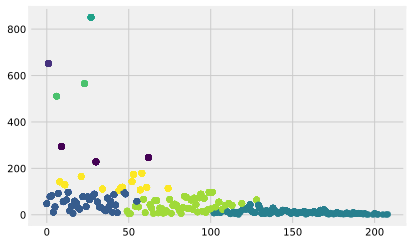

In [172]:
plt.scatter(train['DistrictId'],  train['SizeDistr'], c=labels_train)

In [160]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

In [161]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [165]:
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators': [150, 200, 250], 
               'max_features': np.arange(5, 9),
               'max_depth': np.arange(5, 10)}]

clf = GridSearchCV(estimator=RFR(random_state=22), 
                   param_grid=parameters,
                   scoring='r2',
                   cv=5)

clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=22, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [173]:
clf.best_params_

{'max_depth': 9, 'max_features': 6, 'n_estimators': 200}

In [174]:
model_rfr  = RFR(max_depth=9, max_features=6, n_estimators=250, random_state=22)

In [175]:
# 1я модель - на объектах из Кластера 0
mod = model_rfr 
res_pred = pd.DataFrame()
for cluster in range(clasters):
    mod.fit(X_train.loc[labels_train==cluster, :],
            y_train[labels_train==cluster])
    y_valid_pred = mod.predict(X_valid.loc[labels_test==cluster, :])
    res_pred = res_pred.append(pd.DataFrame({'y_valid': y_valid[labels_test==cluster],
                               'y_pred': y_valid_pred.flatten()}, columns=['y_valid', 'y_pred']))
    print(f'{r2(y_valid[labels_test==cluster], y_valid_pred)}\n')
    

0.6286085919863393

0.7080329699586722

0.6272097897771605

0.5032863181745938

0.7566090381376476

0.8699623354434534

0.6876018437750225

0.6966677643542571



In [163]:
res_pred.head()

,y_valid,y_pred
2077,113252.747810,114973.563894
7099,65410.074769,71975.458210
779,136537.147348,145892.761985
1729,122922.189564,132630.466141
3233,111490.442726,128249.285158


In [164]:
# R2 по всем объектам тестовой выборки
r2(res_pred['y_valid'], res_pred['y_pred'])

0.7101839300202359

#### RandomForest для одного клатера

In [102]:
X_train = train.loc[train['DistrictId'] == 27,cols_for_scale]
y_train = train.loc[train['DistrictId'] == 27,'Price']#train_scaled_price['Price']

X_valid = valid.loc[valid['DistrictId'] == 27,cols_for_scale]
y_valid = valid.loc[valid['DistrictId'] == 27,'Price']#valid_scaled_price['Price']




# X_train = train_scaled_st.loc
# y_train = train_scaled_price['Price']

# X_valid = valid_scaled_st
# y_valid = valid_scaled_price['Price']

model_rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False, random_state=22,
           verbose=0, warm_start=False)

In [103]:
y_predict = model_rfr.predict(X_valid)
check_test = pd.DataFrame({'y_valid': y_valid, 
                           'y_predict': y_predict.flatten()}, columns=['y_valid', 'y_predict'])

In [104]:
check_test.shape

(268, 2)

In [105]:
check_test.head(10)

,y_valid,y_predict
9479,147475.061970,140777.594540
2176,151229.117658,139330.902338
5245,127291.380338,133665.126923
3170,182642.355518,162391.253383
5278,145057.208975,141960.238839
1884,67343.133878,197716.773125
3014,99838.186877,110177.668504
4325,130190.643579,137637.728975
4641,195469.502016,190542.614585
835,104457.850907,115742.093043


##### Оценка результатов

In [106]:
from sklearn.metrics import r2_score as r2
r2(y_valid, y_predict)

0.7566090381376476

In [ ]:
mean_squared_error(res_pred['y_valid'], res_pred['y_pred'])

In [ ]:
train.loc[labels_train==4, :]

In [ ]:
train.loc[labels_train==0, :]

#####  Выберем все данные с коректными данными

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

Отсечем экстремальные значения

In [ ]:
data_train.loc[data_train['Square'] > 200 ,:]

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
# data_train = data_train.drop(data_train.loc[data_train['Square']>200,:].index)

In [ ]:
train.loc[train['DistrictId'] == 27,:]

In [ ]:
data_train['DistrictId'].value_counts()

In [ ]:
data_train['HouseYear'].value_counts()

In [ ]:
data_train.loc[data_train['HouseYear'] > 100,:]

In [ ]:
data_train['HouseFloor'].value_counts()

In [ ]:
data_train['DistrFlat'] = 

In [ ]:
data_train.loc[data_train['HouseFloor'] == 117,'HouseFloor'] = 17